# DATA SCIENCE SESSIONS VOL. 3
### A Foundational Python Data Science Course
## Tasklist 16: Binomial Logistic Regression. 

[&larr; Back to course webpage](https://datakolektiv.com/)

Feedback should be send to [goran.milovanovic@datakolektiv.com](mailto:goran.milovanovic@datakolektiv.com). 

These notebooks accompany the DATA SCIENCE SESSIONS VOL. 3 :: A Foundational Python Data Science Course.

![](../img/IntroRDataScience_NonTech-1.jpg)

### Lecturers

[Goran S. Milovanović, PhD, DataKolektiv, Chief Scientist & Owner](https://www.linkedin.com/in/gmilovanovic/)

[Aleksandar Cvetković, PhD, DataKolektiv, Consultant](https://www.linkedin.com/in/alegzndr/)

[Ilija Lazarević, MA, DataKolektiv, Consultant](https://www.linkedin.com/in/ilijalazarevic/)

![](../img/DK_Logo_100.png)

***

### Intro 

In this Tasklist you'll get to implement Binomial Logistic Regression. This notebook is intended to be used alongside with the notebooks from live sessions and previous tasklists. We'll try to keep things simple here - for EDAs of the given dataset it will suffice to give some basic information and plot some simple graphs. As for ML the model, it doesn't need to be highly accurate - here, the goal is just to implement `statsmodels`, and interpret the results. So, let's dig in!

In [1]:
# suppressing those annoying warnings
import warnings

warnings.filterwarnings("ignore")

In [2]:
# importing necessary libraries
import os 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy import stats 

from statsmodels.regression.linear_model import RegressionResultsWrapper

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [3]:
# setting the working directory

work_dir = os.getcwd()
data_dir = os.path.join(work_dir, "_data")
os.listdir(data_dir)

['binary.csv',
 'churn_data 2.csv',
 'churn_data.csv',
 'Fish.csv',
 'Iris.csv',
 'winequality-red.csv',
 'winequality-white.csv',
 'winequality.names']

## Binomial Logistic Regression

**00.** You'll implement BLR on [*ULCA Admission*](https://stats.idre.ucla.edu/stat/data/binary.csv) dataset, which lists various scores of candidates, based on their success in previous education stage, and whether the candidate was accepted to ULCA or not. The name of this dataset file is `binary.csv`. 

In [4]:
# importing the dataset
df = pd.read_csv(os.path.join(data_dir, 'binary.csv'))
df

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4
...,...,...,...,...
395,0,620,4.00,2
396,0,560,3.04,3
397,0,460,2.63,2
398,0,700,3.65,2


The fields of this dataset are:

- `admit`: binary variable; whether the candidate is accepted `[1]` or not `[0]` to ULCA. This is going to be our target variable;


- `gre`: *Graduate Record Examinations* - score of the GRE exam, a standardized exam, required for admission to gradute programs (prijemni);


- `gpa`: *Grade Point Average* - score based on candidate's grades in previous education stage on 1.0 - 4.0 scale;


- `rank`: categorical variable; - candidate's rank based on his succes in previous education stage, compared to other students in their class on 1 - 4 discrete scale. A candidate with low `gpa` score and high rank is an indication that they come from a weaker class; a candidate with high `gpa` score and low rank comes from though class.

**01.** Let's inspect our data using `.info()` method:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   admit   400 non-null    int64  
 1   gre     400 non-null    int64  
 2   gpa     400 non-null    float64
 3   rank    400 non-null    int64  
dtypes: float64(1), int64(3)
memory usage: 12.6 KB


As we see, there are no `NaN` values, which is good. However, `rank`, which is a categorical variable is read as a numerical variable. 

Now, using `pd.CategoricalDtype` with argument `ordered=True`, cast the `rank` column to categorical type.

In [37]:
# = Notice that we list ranks in reverse: 4th rank is actually the lowest rank!

cat_type = pd.CategoricalDtype(categories=[4, 3, 2, 1], ordered=True)
df['rank'] = df['rank'].astype(cat_type)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   admit   400 non-null    int64   
 1   gre     400 non-null    int64   
 2   gpa     400 non-null    float64 
 3   rank    400 non-null    category
dtypes: category(1), float64(1), int64(2)
memory usage: 10.1 KB


In [38]:
df['rank']

0      3
1      3
2      1
3      4
4      4
      ..
395    2
396    3
397    2
398    2
399    3
Name: rank, Length: 400, dtype: category
Categories (4, int64): [4 < 3 < 2 < 1]

**02.** Perform some elementary EDA to depict how the values of `gre`, `gpa` and `rank` are distributed among the binary values of `admint` target variable. 

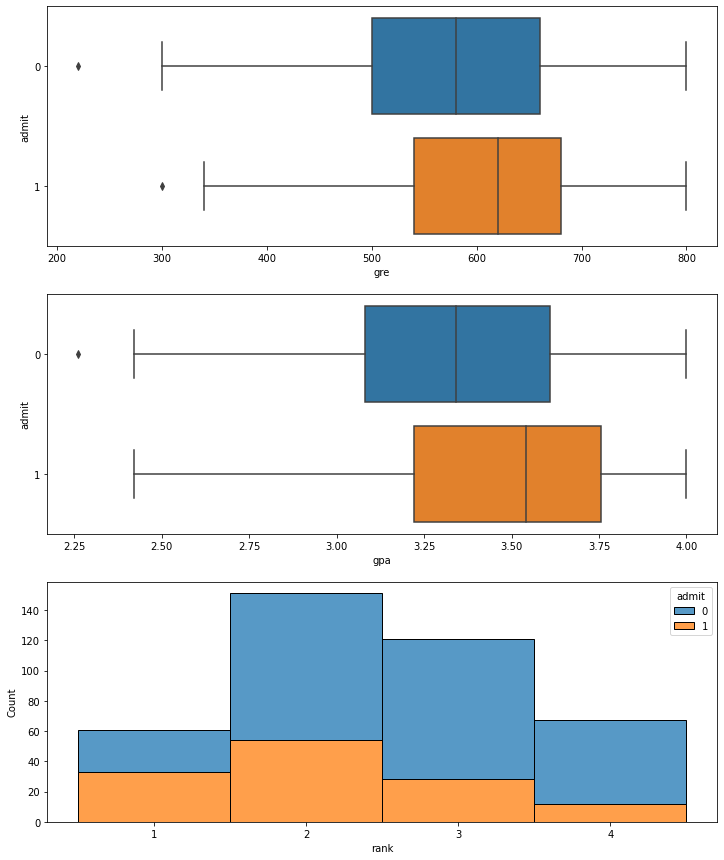

In [39]:
fig, ax = plt.subplots(3, 1, figsize=(12, 15))

sns.boxplot(ax=ax[0], data=df, x='gre', y='admit', orient='h');
sns.boxplot(ax=ax[1], data=df, x='gpa', y='admit', orient='h');
sns.histplot(ax=ax[2], data=df, x='rank', hue='admit', stat='count', multiple='stack');

ax[2].set_xticks([1, 2, 3, 4]);

We notice some outliers in `gre` and `gpa`. Also we can see that there might be some slight imbalance in the data in favor of not admitted. Let's check this out.

In [40]:
df['admit'].value_counts(normalize=True)

0    0.6825
1    0.3175
Name: admit, dtype: float64

The imbalance is actually not that slight at all - there are two times more non-admitted candidates!

**03.** Compute the correlation between the values of numerical variables in this data? Are these results statistically significant?  

In [42]:
df[['gre', 'gpa']].corr(method='pearson')

,gre,gpa
gre,1.000000,0.384266
gpa,0.384266,1.000000


There actually isn't some significant correlation between the given variables. But is this result statistically significant?

In [43]:
stats.pearsonr(df['gre'], df['gpa'])

(0.38426587802084944, 1.595773903084386e-15)

With $p$-value $\approx 0$ we can consider this result statistically significant.

**04.** Use `.logit()` from `stasmodels` to fit a Binomial Logistic Regression model to the given data; this model should predict probabilities for `admit` binary labels from all the other variables.

In [45]:
### --- Prepering the dataset

predictors = df.columns.drop('admit')
predictors

Index(['gre', 'gpa', 'rank'], dtype='object')

In [46]:
# --- Composing the fomula of the model

# - right side of the formula
formula = ' + '.join(predictors)

# - left side of the formula
formula = 'admit ~ ' + formula

formula

'admit ~ gre + gpa + rank'

In [48]:
binomial_linear_model = smf.logit(formula=formula, data=df).fit()

Optimization terminated successfully.
         Current function value: 0.573147
         Iterations 6


**05.** Looking at the model summary, answer: Is the model statistically significant? What about the predictors of the model?

In [51]:
binomial_linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  admit   No. Observations:                  400
Model:                          Logit   Df Residuals:                      394
Method:                           MLE   Df Model:                            5
Date:                Sat, 06 May 2023   Pseudo R-squ.:                 0.08292
Time:                        17:41:41   Log-Likelihood:                -229.26
converged:                       True   LL-Null:                       -249.99
Covariance Type:            nonrobust   LLR p-value:                 7.578e-08
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.5414      1.138     -4.869      0.000      -7.772      -3.311
rank[T.3]      0.2113      0.393      0.538      0.591      -0.559       0.981
rank[T.2]      0.8760      0.367      2.389      0.017       0.157       1.595
rank[T.1]      1.5515      0.418      3.713      0.000       0.733       2.370
gre            0.0023      0.001      2.070      0.038       0.000       0.004
gpa            0.8040      0.332      2.423      0.015       0.154       1.454
==============================================================================
"""

With $p$-value $\approx 0$ we can consider this result statistically significant. As for the predictors, all but `rank` = 3 class, are statistically significant.  

**06.** Interpret the values of model coefficients. 

*Hint:* Try taking their exponentials.

In [52]:
np.exp(binomial_linear_model.params)

Intercept    0.003921
rank[T.3]    1.235233
rank[T.2]    2.401325
rank[T.1]    4.718371
gre          1.002267
gpa          2.234545
dtype: float64

Taking the exponentials of the model coefficients, we conclude the following:

- Being of `rank` = 2 or `rank` = 1 increases the odds of being addmited; escpecially if the candidate is of the 1st rank. Note that we are taking `rank` = 4 as a reference category, so we might also interpret these results as: if the candidate would raise they rank from the lowest to the first two (all other stats being equal) their odds for being admitted would've increased as well.

- The same holds true for increasing to `rank` = 3, but note that we cannot consider this result to be statistically significant. 

- Increasing `gre` doesn't seem to improve candidate's odds for admittance significantly.

- Increasing `gpa` does well improve candidate's odds to be admitted. 

From all said, we can see that being in first two ranks and obtaining a high `gpa` score is mostly important for a candidate to be admitted. 

**07.** Use the model on train data to predict the probabilities of a candidate being admitted to ULCA. We predict that a candidate will be admitted if the predicted probability is higher than 0.5.

In [55]:
probabilities = binomial_linear_model.predict()
predictions = (probabilities > .5).astype('int')

In [56]:
predictions_df = pd.DataFrame()

predictions_df['observation'] = df['admit']
predictions_df['prediction'] = predictions

predictions_df.head()

,observation,prediction
0,0,0
1,1,0
2,1,1
3,1,0
4,0,0


**08.** Evaluate model performance on train data by calculating its accuracy.

In [57]:
# - accuracy of the model
accuracy = predictions_df['observation'] == predictions_df['prediction']
accuracy = np.sum(accuracy)/len(accuracy)
np.round(accuracy, 4)

0.71

**09.** What is the log-likelihood of the model?

In [58]:
# - Log-likelihood of model
model_loglike = binomial_linear_model.llf
model_loglike

-229.25874623794948

**Note:** A good further exercise could be improving the accuracy of the model. Even from EDA we can already see what steps could be undertaken: checking those two outliers `gre` and the one in `gpa`. Also, balancing the dataset is another way to go. 

***

DataKolektiv, 2022/23.

[hello@datakolektiv.com](mailto:goran.milovanovic@datakolektiv.com)

![](../img/DK_Logo_100.png)

<font size=1>License: [GPLv3](https://www.gnu.org/licenses/gpl-3.0.txt) This Notebook is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version. This Notebook is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details. You should have received a copy of the GNU General Public License along with this Notebook. If not, see http://www.gnu.org/licenses/.</font>